In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.calibration import CalibratedClassifierCV

from pathlib import Path

# Load data
project_root = Path.cwd().resolve()
csv_path = project_root.parent / "data" / "creditcard.csv"
if not csv_path.exists():
    csv_path = project_root / "data" / "creditcard.csv"
df = pd.read_csv(csv_path)

X = df.drop("Class", axis=1)
y = df["Class"]

# train-val-test split
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42
)

In [5]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

rf_probs = rf.predict_proba(X_test)

def entropy(p):
    return -np.sum(p*np.log(p+1e-9), axis=1)

rf_acc = accuracy_score(y_test, np.argmax(rf_probs, axis=1))
rf_conf = np.mean(np.max(rf_probs, axis=1))
rf_ent = np.mean(entropy(rf_probs))

print("RF Accuracy:", rf_acc)
print("RF Mean Confidence:", rf_conf)
print("RF Mean Entropy:", rf_ent)


RF Accuracy: 0.9994908886626171
RF Mean Confidence: 0.9994010041782241
RF Mean Entropy: 0.002278866304066771


In [6]:
# Expected Calibration Error (ECE)
def expected_calibration_error(probs, y, n_bins=10):
    confidences = np.max(probs, axis=1)
    predictions = np.argmax(probs, axis=1)

    bins = np.linspace(0,1,n_bins+1)
    ece = 0.0

    for i in range(n_bins):
        idx = (confidences > bins[i]) & (confidences <= bins[i+1])
        if np.sum(idx) == 0:
            continue

        acc = np.mean(predictions[idx] == y.iloc[idx])
        conf = np.mean(confidences[idx])
        ece += np.abs(acc - conf) * np.sum(idx) / len(y)

    return ece

In [7]:
rf_sig = CalibratedClassifierCV(rf, method="sigmoid", cv="prefit")
rf_sig.fit(X_val, y_val)

rf_iso = CalibratedClassifierCV(rf, method="isotonic", cv="prefit")
rf_iso.fit(X_val, y_val)

raw_probs = rf.predict_proba(X_test)
sig_probs = rf_sig.predict_proba(X_test)
iso_probs = rf_iso.predict_proba(X_test)

def summarize(p, name):
    print(name,
          "Conf:", np.mean(np.max(p,1)),
          "Ent:", np.mean(entropy(p)),
          "ECE:", expected_calibration_error(p, y_test.reset_index(drop=True)))

summarize(raw_probs, "Raw RF")
summarize(sig_probs, "Sig RF")
summarize(iso_probs, "Iso RF")

c:\Users\mukun\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
c:\Users\mukun\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


Raw RF Conf: 0.9994010041782241 Ent: 0.002278866304066771 ECE: 0.00020627786945677062
Sig RF Conf: 0.9994774068539198 Ent: 0.0041119072577247215 ECE: 0.00017007502174036805
Iso RF Conf: 0.9993553538382746 Ent: 0.003196639778434654 ECE: 0.00026267966199617374


In [8]:
rf_results = []

def noise_drift(X, intensity):
    return X + np.random.normal(0, intensity, X.shape)

drift_levels = [0.0, 0.2, 0.5, 1.0]

for d in drift_levels:
    Xd = noise_drift(X_test, d)

    rp = rf.predict_proba(Xd)
    sp = rf_sig.predict_proba(Xd)
    ip = rf_iso.predict_proba(Xd)

    rf_results.append([
        d,
        accuracy_score(y_test, np.argmax(rp,1)),
        accuracy_score(y_test, np.argmax(sp,1)),
        accuracy_score(y_test, np.argmax(ip,1)),
        np.mean(np.max(rp,1)),
        np.mean(np.max(sp,1)),
        np.mean(np.max(ip,1)),
        np.mean(entropy(rp)),
        np.mean(entropy(sp)),
        np.mean(entropy(ip))
    ])

rf_results


[[0.0,
  0.9994908886626171,
  0.9995084442259752,
  0.9994908886626171,
  np.float64(0.9994010041782241),
  np.float64(0.9994774068539198),
  np.float64(0.9993553538382746),
  np.float64(0.002278866304066771),
  np.float64(0.0041119072577247215),
  np.float64(0.003196639778434654)],
 [0.2,
  0.999420666409185,
  0.999403110845827,
  0.999403110845827,
  np.float64(0.9990713106983603),
  np.float64(0.999452962769689),
  np.float64(0.9991863228894518),
  np.float64(0.0039254408906236535),
  np.float64(0.004177538158555904),
  np.float64(0.004087771842861116)],
 [0.5,
  0.9993504441557529,
  0.9993679997191109,
  0.9993504441557529,
  np.float64(0.9983034303570801),
  np.float64(0.9994297785897581),
  np.float64(0.9987241783804296),
  np.float64(0.008086895477844408),
  np.float64(0.004257731424147915),
  np.float64(0.006525264846702096)],
 [1.0,
  0.9991222218320986,
  0.9991748885221726,
  0.9991397773954567,
  np.float64(0.9954395035286682),
  np.float64(0.9993652987992391),
  np.floa

In [12]:
columns = [
    "drift",
    "raw_acc", "sig_acc", "iso_acc",
    "raw_conf", "sig_conf", "iso_conf",
    "raw_ent", "sig_ent", "iso_ent"
]

rf_df = pd.DataFrame(rf_results, columns=columns)
rf_df.to_csv("rf_results.csv", index=False)


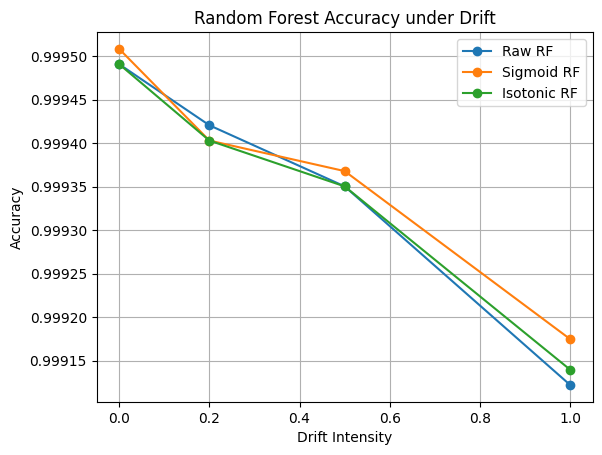

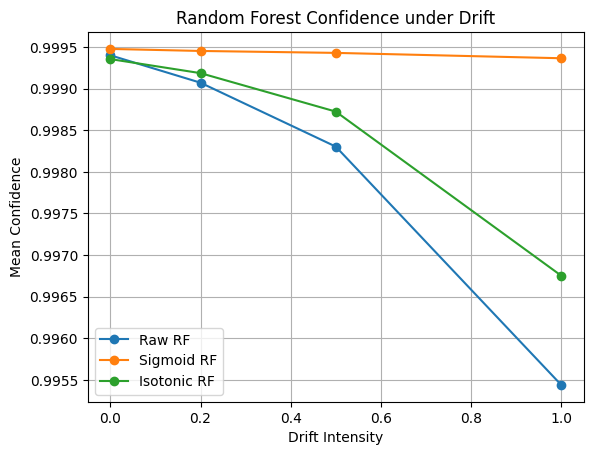

In [9]:
drift = [r[0] for r in rf_results]

raw_acc = [r[1] for r in rf_results]
sig_acc = [r[2] for r in rf_results]
iso_acc = [r[3] for r in rf_results]

plt.figure()
plt.plot(drift, raw_acc, marker='o')
plt.plot(drift, sig_acc, marker='o')
plt.plot(drift, iso_acc, marker='o')

plt.xlabel("Drift Intensity")
plt.ylabel("Accuracy")
plt.title("Random Forest Accuracy under Drift")
plt.legend(["Raw RF", "Sigmoid RF", "Isotonic RF"])
plt.grid(True)
plt.show()

raw_conf = [r[4] for r in rf_results]
sig_conf = [r[5] for r in rf_results]
iso_conf = [r[6] for r in rf_results]

plt.figure()
plt.plot(drift, raw_conf, marker='o')
plt.plot(drift, sig_conf, marker='o')
plt.plot(drift, iso_conf, marker='o')

plt.xlabel("Drift Intensity")
plt.ylabel("Mean Confidence")
plt.title("Random Forest Confidence under Drift")
plt.legend(["Raw RF", "Sigmoid RF", "Isotonic RF"])
plt.grid(True)
plt.show()
